<a href="https://colab.research.google.com/github/KBG1990/Estimating-quantum-non-Markovianity-using-machine-learning/blob/main/Testing_experimental_data_with_different_ratio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries

In [ ]:
pip install -U keras 

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [ ]:
import pandas as pd
import numpy as np


import os
import sys

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
import seaborn as sb
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import generic_utils # For progress bar

import keras.backend as K

# General support
import math
import tensorflow as tf

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score


# Dimensionality reduction
import umap
#from sklearn.manifold import TSNE


In [ ]:
from scipy.linalg import sqrtm
A = np.array([[0.36934579,0.34126931,0.34126931],[0.34126931, 0.3153271, 0.3153271],[0.34126931, 0.3153271, 0.3153271]])
sqrtm(A)

array([[0.3693458 +6.36302722e-05j, 0.34126931-3.44325920e-05j,
        0.34126931-3.44325919e-05j],
       [0.34126931-3.44325920e-05j, 0.3153271 +1.86326940e-05j,
        0.3153271 +1.86326940e-05j],
       [0.34126931-3.44325920e-05j, 0.3153271 +1.86326940e-05j,
        0.3153271 +1.86326940e-05j]])

In [ ]:
def Fidelity(a,b):
  from scipy.linalg import sqrtm
  import numpy as np
  sqrt_a = sqrtm(a)
  x = np.linalg.multi_dot([sqrt_a,b,sqrt_a])
  return  np.trace(sqrtm(x))


In [ ]:

a = np.array([[1,0],[0,0]])
b = np.array([[0,0],[0,1]])
p = 0.7
q = 0.2
c = p* a + (1-p)*b
d = q*a + (1-q) *b

check = np.sqrt(p*q)+np.sqrt((1-p)*(1-q)) # Should be equal to fidelity between c and d, ref Mike and Ike

print('Does it work if one of them is a pure state?\n', Fidelity(a,c)**2) # You should get p here
print('Does it work if one of them is a pure state?\n', Fidelity(a,d)**2) # You should get q here
print('Fidelity =',Fidelity(c,d))
print(check)

Does it work if one of them is a pure state?
 0.7000000000000001
Does it work if one of them is a pure state?
 0.19999999999999998
Fidelity = 0.8640636872340299
0.8640636872340297


# Change the directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/NON_MARKOV_KBG/

/content/drive/My Drive/Colab Notebooks/NON_MARKOV_KBG


# Uploading and Shuffling the simulated dataset and the experimental dataset

In [ ]:
Simulated_data = pd.read_csv('Sim_data_Pauli_wide_range.csv')
#Simulated_data = pd.read_csv('Sim_data_Pauli_concentrated.csv')
#Simulated_data = pd.read_csv('Sim_data_Pauli_wide_range2.csv')
experimental_data = pd.read_csv('experimental_data_new_set_1000.csv', header=None)
#sim_50_sample_data = pd.read_csv('50_sample_data_another_new_set_1000.csv', header=None)
#sim_200_sample_data = pd.read_csv('200_sample_data_another_new_set_1000.csv', header=None)

In [ ]:
df1 = Simulated_data.iloc[:,:]
df1.drop("Unnamed: 0", axis=1, inplace=True)
df1 = df1.rename(columns = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, 'Labels':9}) ## This step is needed to match the names of the columns with the experimental data


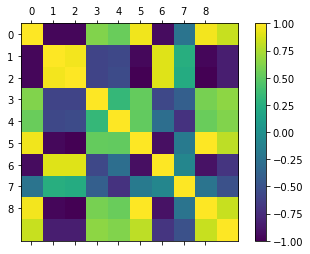

In [ ]:
correlations = df1.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

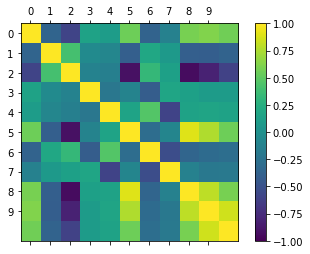

In [ ]:
correlations2 = experimental_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations2, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,10,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

In [ ]:
import sklearn as sk

Shuffled_experimental_data = sk.utils.shuffle(sim_50_sample_data, random_state=10)
Shuffled_simulated_data = sk.utils.shuffle(df1, random_state=10)             ## In last two lines, I shuffled the simulated and the experimental datasets, this steps are required to randomly select certain percentage of the rows from both of them. 

print(Shuffled_experimental_data.iloc[0:2,:])
print(Shuffled_simulated_data.iloc[0:2,:])

Simulated_data_row, Simulated_data_column = Shuffled_simulated_data.shape
Exp_data_row, Exp_data_column = Shuffled_experimental_data.shape

print(Simulated_data_row)
print(Exp_data_row)


          0         1        2        3   ...        7        8        9        10
841  0.27329  0.149070 -0.95031  0.14032  ...  0.110840  0.93831  0.96962  0.82026
956  0.30986 -0.075701 -0.88238  0.50200  ... -0.044683  0.98325  0.92536  0.99204

[2 rows x 11 columns]
              0         1         2  ...         7         8         9
45609  0.260029 -0.141833 -0.897570  ... -0.125910  0.900072  0.812942
34085  0.236737 -0.117753 -0.757005  ... -0.080832  0.760656  0.514840

[2 rows x 10 columns]
57344
1000


## Training and testing on only simulated data

In [ ]:

from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(Shuffled_simulated_data.iloc[:,[2,5,8]].values, Shuffled_simulated_data.iloc[:,-1].values, test_size=0.33, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(Shuffled_simulated_data.iloc[:,0:9].values, Shuffled_simulated_data.iloc[:,-1].values, test_size=0.33, random_state=42)




print('First two rows of the training dataset\n',X_train[0:2,:])
print('\nShape of the training dataset = ', X_train.shape)

print('\nFirst two rows of the test dataset\n', X_test[0:2,:])
print('\nShape of the test dataset = ', X_test.shape)

First two rows of the training dataset
 [[ 0.12050195 -0.07736718 -0.44298099  0.02461086  0.03185918  0.4553948
  -0.1184138   0.03294314  0.44318722]
 [ 0.19096372 -0.11319688 -0.72127507  0.05138817  0.0644544   0.734252
  -0.19328754  0.04044073  0.72319349]]

Shape of the training dataset =  (38420, 9)

First two rows of the test dataset
 [[ 0.27329193 -0.14906832 -0.95031056  0.03243975  0.10937738  0.95596377
  -0.18956109 -0.11389201  0.94424203]
 [ 0.24556989 -0.13624214 -0.84526679  0.08887125  0.12325136  0.82870008
  -0.16119173 -0.13183171  0.84113881]]

Shape of the test dataset =  (18924, 9)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=4)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)   

0.9980420777519295
0.010358999526617478
0.9984467342323632
0.0097848061791111


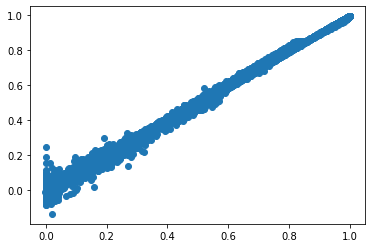

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions1 = model_poly.predict(x_poly_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)


mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
mae_2_train = metrics.mean_absolute_error(y_train,predictions1)
r2_2_train = r2_score(y_train,predictions1)
r2_2 = r2_score(y_test,predictions2)  
print(r2_2)
print(mae_2)
print(r2_2_train)
print(mae_2_train)




## Training with 100% simulated data and 70% experimental data

In [ ]:


n_simulated = 0/100    
n_experiment = 70/100 


#frame = [Shuffled_simulated_data.iloc[0: int(Simulated_data_row*n_simulated),:], Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),[3,6,9]]]]]
#Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)                   

Concatenated_data = Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),[2,5,8,9]]

Tst_set = Shuffled_experimental_data.iloc[int(Exp_data_row*n_experiment):1000,[2,5,8,9]]
Test_set = Tst_set.reset_index(drop=True)


print('First two rows of the training dataset\n',Concatenated_data.iloc[0:2,:])
print('\nShape of the training dataset = ', Concatenated_data.shape)

print('\nFirst two rows of the test dataset\n', Test_set.iloc[0:2,:])
print('\nShape of the test dataset = ', Test_set.shape)

First two rows of the training dataset
            2        5        8        9
841 -0.95031  0.94351  0.93831  0.96962
956 -0.88238  0.86042  0.98325  0.92536

Shape of the training dataset =  (700, 4)

First two rows of the test dataset
          2        5        8        9
0 -0.87429  0.84617  0.85440  0.68924
1 -0.91230  0.85477  0.88089  0.51523

Shape of the test dataset =  (300, 4)


In [ ]:
X_train = Concatenated_data.iloc[:,0:3].values
y_train = Concatenated_data.iloc[:,-1].values

X_test = Test_set.iloc[:,0:3].values
y_test = Test_set.iloc[:,-1].values

### Polynomial Regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)   

0.6801484993757838
0.07770117846727734
0.6792103847281947
0.07676717041442353


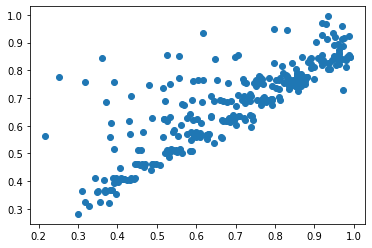

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions1 = model_poly.predict(x_poly_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)


mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
mae_2_train = metrics.mean_absolute_error(y_train,predictions1)
r2_2_train = r2_score(y_train,predictions1)
r2_2 = r2_score(y_test,predictions2)  
print(r2_2)
print(mae_2)
print(r2_2_train)
print(mae_2_train)


#### R2 Score with regression
1.   0.64
2.   0.85



### Neural Network

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/20
371/374 [============================>.] - ETA: 0s - loss: 0.1049 - mean_absolute_error: 0.1049
Epoch 00001: val_loss improved from inf to 0.06622, saving model to Weights-001--0.06622.hdf5
374/374 [==============================] - 1s 4ms/step - loss: 0.1045 - mean_absolute_error: 0.1045 - val_loss: 0.0662 - val_mean_absolute_error: 0.0662
Epoch 2/20
369/374 [============================>.] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.0427
Epoch 00002: val_loss improved from 0.06622 to 0.03146, saving model to Weights-002--0.03146.hdf5
374/374 [==============================] - 1s 3ms/step - loss: 0.0426 - mean_absolute_error: 0.0426 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 3/20
363/374 [============================>.] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352
Epoch 00003: val_loss improved from 0.03146 to 0.02612, saving model to Weights-003--0.02612.hdf5
374/374 [==============================] - 1s 3ms/step - loss: 0.0350 - mean_absolu

In [ ]:
predictions_NN_model = NN_model.predict(X_test)


R2_score = r2_score(y_test , predictions_NN_model)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
print('MAE=',MAE)


R2_score =  0.838940126464659
MAE= 0.05713913233703374


## Training with 80% Simulated data and 60% Experimental data

In [ ]:
n_simulated =  0.8    
n_experiment = 0.6 


frame = [Shuffled_simulated_data.iloc[0: int(Simulated_data_row*n_simulated),:], Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),0:10]]
Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)

Tst_set = Shuffled_experimental_data.iloc[int(Exp_data_row*n_experiment):1000,0:10]
Test_set = Tst_set.reset_index(drop=True)


print('First two rows of the training dataset\n',Concatenated_data.iloc[0:2,:])
print('\nShape of the training dataset = ', Concatenated_data.shape)

print('\nFirst two rows of the test dataset\n', Test_set.iloc[0:2,:])
print('\nShape of the test dataset = ', Test_set.shape)

First two rows of the training dataset
           0         1         2  ...         7         8         9
0  0.247066 -0.134443 -0.847967  ... -0.028091  0.847865  0.650680
1  0.260906 -0.141703 -0.903978  ... -0.096278  0.904922  0.826874

[2 rows x 10 columns]

Shape of the training dataset =  (12068, 10)

First two rows of the test dataset
          0         1        2        3  ...        6         7        8        9
0  0.22737 -0.084502 -0.71269  0.20063  ... -0.13539 -0.067570  0.79156  0.49154
1  0.28010 -0.061333 -0.73534  0.30589  ... -0.12795  0.011258  0.80053  0.51405

[2 rows x 10 columns]

Shape of the test dataset =  (400, 10)


In [ ]:
X_train = Concatenated_data.iloc[:,0:9].values
y_train = Concatenated_data.iloc[:,-1].values

X_test = Test_set.iloc[:,0:9].values
y_test = Test_set.iloc[:,-1].values

### Polynomial Regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)

0.053668562041464495

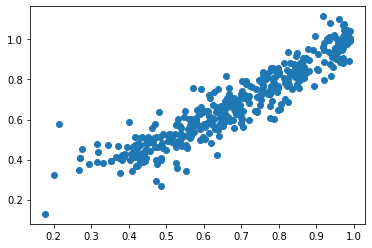

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)


mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
r2_2 = r2_score(y_test,predictions2)  
r2_2
mae_2

#### Summary of the regression results: (R^2 values for different degrees)


1.   0.645
2.   0.856

### Neural Network

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20
296/302 [============================>.] - ETA: 0s - loss: 0.1162 - mean_absolute_error: 0.1162
Epoch 00001: val_loss improved from inf to 0.08124, saving model to Weights-001--0.08124.hdf5
302/302 [==============================] - 1s 4ms/step - loss: 0.1152 - mean_absolute_error: 0.1152 - val_loss: 0.0812 - val_mean_absolute_error: 0.0812
Epoch 2/20
301/302 [============================>.] - ETA: 0s - loss: 0.0499 - mean_absolute_error: 0.0499
Epoch 00002: val_loss improved from 0.08124 to 0.03946, saving model to Weights-002--0.03946.hdf5
302/302 [==============================] - 1s 3ms/step - loss: 0.0499 - mean_absolute_error: 0.0499 - val_loss: 0.0395 - val_mean_absolute_error: 0.0395
Epoch 3/20
299/302 [============================>.] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380
Epoch 00003: val_loss did not improve from 0.03946
302/302 [==============================] - 1s 3ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0434 - val_mean_

In [ ]:
predictions_NN_model = NN_model.predict(X_test)


R2_score = r2_score(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('MAE=', MAE)

R2_score =  0.8558680472701441
MAE= 0.05441701242665053


## Training with 60% Simulated data and 60% Experimental data

In [ ]:
n_simulated =  0.6    
n_experiment = 0.6 


frame = [Shuffled_simulated_data.iloc[0: int(Simulated_data_row*n_simulated),:], Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),0:10]]
Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)

Tst_set = Shuffled_experimental_data.iloc[int(Exp_data_row*n_experiment):1000,0:10]
Test_set = Tst_set.reset_index(drop=True)


print('First two rows of the training dataset\n',Concatenated_data.iloc[0:2,:])
print('\nShape of the training dataset = ', Concatenated_data.shape)

print('\nFirst two rows of the test dataset\n', Test_set.iloc[0:2,:])
print('\nShape of the test dataset = ', Test_set.shape)

First two rows of the training dataset
           0         1         2  ...         7         8         9
0  0.247066 -0.134443 -0.847967  ... -0.028091  0.847865  0.650680
1  0.260906 -0.141703 -0.903978  ... -0.096278  0.904922  0.826874

[2 rows x 10 columns]

Shape of the training dataset =  (9201, 10)

First two rows of the test dataset
          0         1        2        3  ...        6         7        8        9
0  0.22737 -0.084502 -0.71269  0.20063  ... -0.13539 -0.067570  0.79156  0.49154
1  0.28010 -0.061333 -0.73534  0.30589  ... -0.12795  0.011258  0.80053  0.51405

[2 rows x 10 columns]

Shape of the test dataset =  (400, 10)


In [ ]:
X_train = Concatenated_data.iloc[:,0:9].values
y_train = Concatenated_data.iloc[:,-1].values

X_test = Test_set.iloc[:,0:9].values
y_test = Test_set.iloc[:,-1].values

### Polynomial Regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)

0.052618058496087715

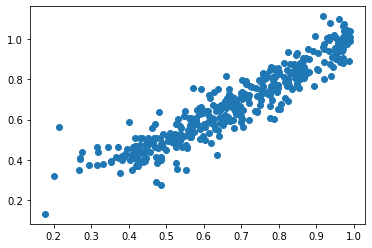

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)


mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
r2_2 = r2_score(y_test,predictions2)  
r2_2
mae_2

#### Summary of the regression results: (R^2 values for different degrees)


1.   0.65
2.   0.86

### Neural Network

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20
212/230 [==========================>...] - ETA: 0s - loss: 0.1423 - mean_absolute_error: 0.1423
Epoch 00001: val_loss improved from inf to 0.10880, saving model to Weights-001--0.10880.hdf5
230/230 [==============================] - 1s 4ms/step - loss: 0.1374 - mean_absolute_error: 0.1374 - val_loss: 0.1088 - val_mean_absolute_error: 0.1088
Epoch 2/20
218/230 [===========================>..] - ETA: 0s - loss: 0.0720 - mean_absolute_error: 0.0720
Epoch 00002: val_loss improved from 0.10880 to 0.05611, saving model to Weights-002--0.05611.hdf5
230/230 [==============================] - 1s 3ms/step - loss: 0.0715 - mean_absolute_error: 0.0715 - val_loss: 0.0561 - val_mean_absolute_error: 0.0561
Epoch 3/20
226/230 [============================>.] - ETA: 0s - loss: 0.0545 - mean_absolute_error: 0.0545
Epoch 00003: val_loss did not improve from 0.05611
230/230 [==============================] - 1s 3ms/step - loss: 0.0546 - mean_absolute_error: 0.0546 - val_loss: 0.0675 - val_mean_

In [ ]:
predictions_NN_model = NN_model.predict(X_test)


R2_score = r2_score(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('MAE=', MAE)

R2_score =  0.8496167319758914
MAE= 0.05604912151395082


## Training with 40% Simulated data and 60% Experimental data

In [ ]:
n_simulated =  0.4    
n_experiment = 0.6 


frame = [Shuffled_simulated_data.iloc[0: int(Simulated_data_row*n_simulated),:], Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),0:10]]
Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)

Tst_set = Shuffled_experimental_data.iloc[int(Exp_data_row*n_experiment):1000,0:10]
Test_set = Tst_set.reset_index(drop=True)


print('First two rows of the training dataset\n',Concatenated_data.iloc[0:2,:])
print('\nShape of the training dataset = ', Concatenated_data.shape)

print('\nFirst two rows of the test dataset\n', Test_set.iloc[0:2,:])
print('\nShape of the test dataset = ', Test_set.shape)

First two rows of the training dataset
           0         1         2  ...         7         8         9
0  0.247066 -0.134443 -0.847967  ... -0.028091  0.847865  0.650680
1  0.260906 -0.141703 -0.903978  ... -0.096278  0.904922  0.826874

[2 rows x 10 columns]

Shape of the training dataset =  (6334, 10)

First two rows of the test dataset
          0         1        2        3  ...        6         7        8        9
0  0.22737 -0.084502 -0.71269  0.20063  ... -0.13539 -0.067570  0.79156  0.49154
1  0.28010 -0.061333 -0.73534  0.30589  ... -0.12795  0.011258  0.80053  0.51405

[2 rows x 10 columns]

Shape of the test dataset =  (400, 10)


In [ ]:
X_train = Concatenated_data.iloc[:,0:9].values
y_train = Concatenated_data.iloc[:,-1].values

X_test = Test_set.iloc[:,0:9].values
y_test = Test_set.iloc[:,-1].values

### Polynomial Regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)

0.05153741897452301

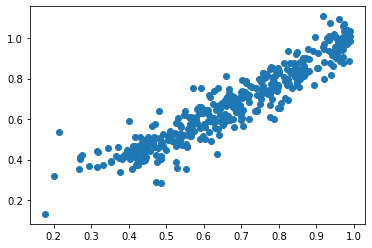

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)


mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
r2_2 = r2_score(y_test,predictions2)  
r2_2
mae_2

#### Summary of the regression results: (R^2 values for different degrees)


1.   0.66
2.   0.87

### Neural Network

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20
155/159 [============================>.] - ETA: 0s - loss: 0.1592 - mean_absolute_error: 0.1592
Epoch 00001: val_loss improved from inf to 0.10652, saving model to Weights-001--0.10652.hdf5
159/159 [==============================] - 1s 5ms/step - loss: 0.1577 - mean_absolute_error: 0.1577 - val_loss: 0.1065 - val_mean_absolute_error: 0.1065
Epoch 2/20
157/159 [============================>.] - ETA: 0s - loss: 0.0759 - mean_absolute_error: 0.0759
Epoch 00002: val_loss improved from 0.10652 to 0.05384, saving model to Weights-002--0.05384.hdf5
159/159 [==============================] - 1s 4ms/step - loss: 0.0757 - mean_absolute_error: 0.0757 - val_loss: 0.0538 - val_mean_absolute_error: 0.0538
Epoch 3/20
156/159 [============================>.] - ETA: 0s - loss: 0.0492 - mean_absolute_error: 0.0492
Epoch 00003: val_loss improved from 0.05384 to 0.04791, saving model to Weights-003--0.04791.hdf5
159/159 [==============================] - 1s 4ms/step - loss: 0.0491 - mean_absolu

In [ ]:
predictions_NN_model = NN_model.predict(X_test)


R2_score = r2_score(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('MAE=', MAE)

R2_score =  0.867024968856923
MAE= 0.050525947196310754


## Training with 20% Simulated data and 60% Experimental data

In [ ]:
n_simulated =  0.2    
n_experiment = 0.6 


frame = [Shuffled_simulated_data.iloc[0: int(Simulated_data_row*n_simulated),:], Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),0:10]]
Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)

Tst_set = Shuffled_experimental_data.iloc[int(Exp_data_row*n_experiment):1000,0:10]
Test_set = Tst_set.reset_index(drop=True)


print('First two rows of the training dataset\n',Concatenated_data.iloc[0:2,:])
print('\nShape of the training dataset = ', Concatenated_data.shape)

print('\nFirst two rows of the test dataset\n', Test_set.iloc[0:2,:])
print('\nShape of the test dataset = ', Test_set.shape)

First two rows of the training dataset
           0         1         2  ...         7         8         9
0  0.247066 -0.134443 -0.847967  ... -0.028091  0.847865  0.650680
1  0.260906 -0.141703 -0.903978  ... -0.096278  0.904922  0.826874

[2 rows x 10 columns]

Shape of the training dataset =  (3467, 10)

First two rows of the test dataset
          0         1        2        3  ...        6         7        8        9
0  0.22737 -0.084502 -0.71269  0.20063  ... -0.13539 -0.067570  0.79156  0.49154
1  0.28010 -0.061333 -0.73534  0.30589  ... -0.12795  0.011258  0.80053  0.51405

[2 rows x 10 columns]

Shape of the test dataset =  (400, 10)


In [ ]:
X_train = Concatenated_data.iloc[:,0:9].values
y_train = Concatenated_data.iloc[:,-1].values

X_test = Test_set.iloc[:,0:9].values
y_test = Test_set.iloc[:,-1].values

### Polynomial Regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)

0.04924466432622936

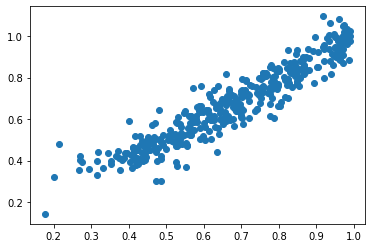

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)


mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
r2_2 = r2_score(y_test,predictions2)  
r2_2
mae_2

#### Summary of the regression results: (R^2 values for different degrees)


1.   0.68
2.   0.88

### Neural Network

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20
83/87 [===========================>..] - ETA: 0s - loss: 0.1917 - mean_absolute_error: 0.1917
Epoch 00001: val_loss did not improve from 0.04680
87/87 [==============================] - 0s 5ms/step - loss: 0.1891 - mean_absolute_error: 0.1891 - val_loss: 0.1331 - val_mean_absolute_error: 0.1331
Epoch 2/20
76/87 [=========================>....] - ETA: 0s - loss: 0.1228 - mean_absolute_error: 0.1228
Epoch 00002: val_loss did not improve from 0.04680
87/87 [==============================] - 0s 4ms/step - loss: 0.1212 - mean_absolute_error: 0.1212 - val_loss: 0.1116 - val_mean_absolute_error: 0.1116
Epoch 3/20
75/87 [========================>.....] - ETA: 0s - loss: 0.0987 - mean_absolute_error: 0.0987
Epoch 00003: val_loss did not improve from 0.04680
87/87 [==============================] - 0s 4ms/step - loss: 0.0949 - mean_absolute_error: 0.0949 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921
Epoch 4/20
71/87 [=======================>......] - ETA: 0s - loss: 0.0681 - me

In [ ]:
predictions_NN_model = NN_model.predict(X_test)


R2_score = r2_score(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('MAE=', MAE)

R2_score =  0.886089366788567
MAE= 0.047864743332040306


## Training with 10% Simulated data and 60% Experimental data

In [ ]:
n_simulated =  0.1    
n_experiment = 0.6 


frame = [Shuffled_simulated_data.iloc[0: int(Simulated_data_row*n_simulated),:], Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),0:10]]
Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)

Tst_set = Shuffled_experimental_data.iloc[int(Exp_data_row*n_experiment):1000,0:10]
Test_set = Tst_set.reset_index(drop=True)


print('First two rows of the training dataset\n',Concatenated_data.iloc[0:2,:])
print('\nShape of the training dataset = ', Concatenated_data.shape)

print('\nFirst two rows of the test dataset\n', Test_set.iloc[0:2,:])
print('\nShape of the test dataset = ', Test_set.shape)

First two rows of the training dataset
           0         1         2  ...         7         8         9
0  0.247066 -0.134443 -0.847967  ... -0.028091  0.847865  0.650680
1  0.260906 -0.141703 -0.903978  ... -0.096278  0.904922  0.826874

[2 rows x 10 columns]

Shape of the training dataset =  (2033, 10)

First two rows of the test dataset
          0         1        2        3  ...        6         7        8        9
0  0.22737 -0.084502 -0.71269  0.20063  ... -0.13539 -0.067570  0.79156  0.49154
1  0.28010 -0.061333 -0.73534  0.30589  ... -0.12795  0.011258  0.80053  0.51405

[2 rows x 10 columns]

Shape of the test dataset =  (400, 10)


In [ ]:
X_train = Concatenated_data.iloc[:,0:9].values
y_train = Concatenated_data.iloc[:,-1].values

X_test = Test_set.iloc[:,0:9].values
y_test = Test_set.iloc[:,-1].values

### Polynomial Regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)

0.04728413343002814

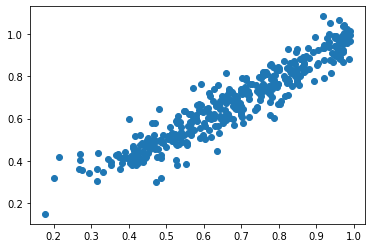

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)


mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
r2_2 = r2_score(y_test,predictions2)  
r2_2
mae_2

#### Summary of the regression results: (R^2 values for different degrees)


1.   0.69
2.   0.89

### Neural Network

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20
38/51 [=====================>........] - ETA: 0s - loss: 0.2541 - mean_absolute_error: 0.2541
Epoch 00001: val_loss improved from inf to 0.12799, saving model to Weights-001--0.12799.hdf5
51/51 [==============================] - 0s 6ms/step - loss: 0.2248 - mean_absolute_error: 0.2248 - val_loss: 0.1280 - val_mean_absolute_error: 0.1280
Epoch 2/20
50/51 [============================>.] - ETA: 0s - loss: 0.1278 - mean_absolute_error: 0.1278
Epoch 00002: val_loss improved from 0.12799 to 0.11849, saving model to Weights-002--0.11849.hdf5
51/51 [==============================] - 0s 5ms/step - loss: 0.1276 - mean_absolute_error: 0.1276 - val_loss: 0.1185 - val_mean_absolute_error: 0.1185
Epoch 3/20
49/51 [===========================>..] - ETA: 0s - loss: 0.1204 - mean_absolute_error: 0.1204
Epoch 00003: val_loss did not improve from 0.11849
51/51 [==============================] - 0s 4ms/step - loss: 0.1201 - mean_absolute_error: 0.1201 - val_loss: 0.1561 - val_mean_absolute_err

In [ ]:
predictions_NN_model = NN_model.predict(X_test)


R2_score = r2_score(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('MAE=', MAE)

R2_score =  0.8967189180951911
MAE= 0.045487914939486986


## Training only with 70% Experimental data (0% simulated data)

In [ ]:
n_simulated =  0   
n_experiment = 0.7 


frame = [Shuffled_simulated_data.iloc[0: int(Simulated_data_row*n_simulated),:], Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),0:10]]
Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)

Tst_set = Shuffled_experimental_data.iloc[int(Exp_data_row*n_experiment):1000,0:10]
Test_set = Tst_set.reset_index(drop=True)


print('First two rows of the training dataset\n',Concatenated_data.iloc[0:2,:])
print('\nShape of the training dataset = ', Concatenated_data.shape)

print('\nFirst two rows of the test dataset\n', Test_set.iloc[0:2,:])
print('\nShape of the test dataset = ', Test_set.shape)

First two rows of the training dataset
          0         1        2       3  ...        6         7        8        9
0  0.31022 -0.130410 -0.92070  0.2266  ... -0.17288 -0.051216  0.96937  0.96381
1  0.30986 -0.075701 -0.88238  0.5020  ... -0.17710 -0.044683  0.98325  0.92536

[2 rows x 10 columns]

Shape of the training dataset =  (700, 10)

First two rows of the test dataset
          0         1        2        3  ...         6         7        8        9
0  0.29936 -0.072687 -0.84203  0.27257  ... -0.214320 -0.033889  0.92509  0.69827
1  0.32097 -0.076999 -0.83218  0.11611  ... -0.094798 -0.202410  0.93217  0.55731

[2 rows x 10 columns]

Shape of the test dataset =  (300, 10)


In [ ]:
X_train = Concatenated_data.iloc[:,0:9].values
y_train = Concatenated_data.iloc[:,-1].values

X_test = Test_set.iloc[:,0:9].values
y_test = Test_set.iloc[:,-1].values

### Polynomial Regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=3)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)

0.855848624862528
0.052116398813677925


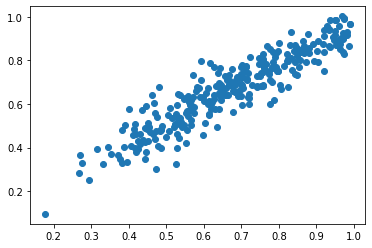

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions2 = model_poly.predict(x_poly_test)
fig = plt.scatter(y_test,predictions2)
plt.savefig('test.pdf')

mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
r2_2 = r2_score(y_test,predictions2)  
print(r2_2)
print(mae_2)

#### Summary of the regression results: (R^2 values for different degrees)


1.   0.71
2.   0.90

### Neural Network

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 0.0759 - mean_absolute_error: 0.0759
Epoch 00001: val_loss did not improve from 0.06031
15/15 [==============================] - 0s 7ms/step - loss: 0.0759 - mean_absolute_error: 0.0759 - val_loss: 0.0640 - val_mean_absolute_error: 0.0640
Epoch 2/20
 1/15 [=>............................] - ETA: 0s - loss: 0.0525 - mean_absolute_error: 0.0525
Epoch 00002: val_loss did not improve from 0.06031
15/15 [==============================] - 0s 4ms/step - loss: 0.0717 - mean_absolute_error: 0.0717 - val_loss: 0.0786 - val_mean_absolute_error: 0.0786
Epoch 3/20
 1/15 [=>............................] - ETA: 0s - loss: 0.0882 - mean_absolute_error: 0.0882
Epoch 00003: val_loss improved from 0.06031 to 0.05459, saving model to Weights-003--0.05459.hdf5
15/15 [==============================] - 0s 7ms/step - loss: 0.0701 - mean_absolute_error: 0.0701 - val_loss: 0.0546 - val_mean_absolute_error: 0.0546
Epoch 4/20
 1/15 [=>............

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
predictions_NN_model = NN_model.predict(X_test)


R2_score = r2_score(y_test , predictions_NN_model)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
print('MAE = ',MAE)

R2_score =  0.8867577450592544
MAE =  0.04873962058657408


In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
#NN_model.summary()

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20
 1/15 [=>............................] - ETA: 0s - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 00001: val_loss did not improve from 0.00388
15/15 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 2/20
 1/15 [=>............................] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 00002: val_loss did not improve from 0.00388
15/15 [==============================] - 0s 4ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 3/20
 1/15 [=>............................] - ETA: 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 00003: val_loss did not improve from 0.00388
15/15 [==============================] - 0s 4ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 4/20
 1/15 [=>............................] - ETA: 0s - loss: 0.0053 - mean_square

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
predictions_NN_model = NN_model.predict(X_test)

R2_score = r2_score(y_test , predictions_NN_model)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
print('MAE = ',MAE)

R2_score =  0.8686892812557622
MAE =  0.053137953382074825


### Let us try cross-validation algorithm with Regression

In [ ]:
X = experimental_data.iloc[:,0:9]
Y_explabel = experimental_data.iloc[:,9]
Y_theorylabel = experimental_data.iloc[:,10]

#print(experimental_data)
#print(Y_explabel)
#print(Y_theorylabel)


In [ ]:
from sklearn.model_selection import KFold
# prepare the cross-validation procedure
fold = KFold(n_splits = 10, shuffle = True, random_state = 100)

In [ ]:
# Prepare the regression model
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X)
model_poly = LinearRegression()


In [ ]:
from sklearn.model_selection import cross_val_score
# evaluate model
scores = cross_val_score(model_poly, x_poly, Y_explabel, scoring='neg_mean_absolute_error', cv=fold)
# report performance

from numpy import mean
from numpy import std
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: -0.045 (0.005)


#### Let us try Repeated K Fold cross validation

In [ ]:
from sklearn.model_selection import RepeatedKFold
# prepare the cross-validation procedure
Repeated_Fold = RepeatedKFold(n_splits=10, n_repeats=5, random_state=10)

In [ ]:
# Prepare the regression model
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=1)
x_poly = polynomial_features.fit_transform(X)
model_poly = LinearRegression()


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# evaluate model
scores = cross_val_score(model_poly, x_poly, Y_explabel, scoring='neg_mean_absolute_error', cv=Repeated_Fold)
# report performance

from numpy import mean
from numpy import std
print('R2: %.3f (%.3f)' % (mean(scores), std(scores)))

R2: -0.076 (0.007)


### Try a NN model and to do a 70-30 split

In [ ]:
X = experimental_data.iloc[:,0:9]
Y_explabel = experimental_data.iloc[:,9]
Y_theorylabel = experimental_data.iloc[:,10]

#print(experimental_data)
#print(Y_explabel)
#print(Y_theorylabel)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y_explabel, test_size=0.3, random_state=42)



In [ ]:
# Make a model


NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.01))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(0.05))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[''])
#NN_model.summary()

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
#train the model, evaluate using 0.2 of data for validation comparison, run for 20 epochs, batch size of 32
NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/20


ValueError: ignored

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
predictions_NN_model = NN_model.predict(X_test)

R2_score = r2_score(y_test , predictions_NN_model)
MAE = mean_absolute_error(y_test , predictions_NN_model)
print('R2_score = ',R2_score)
print('MAE = ',MAE)


R2_score =  0.8813261129413127
MAE =  0.04713472002011934


#### Let's try K-Fold cross validation on NN

In [ ]:
X = experimental_data.iloc[:,0:9]
Y_explabel = experimental_data.iloc[:,9]
Y_theorylabel = experimental_data.iloc[:,10]

#print(experimental_data)
#print(Y_explabel)
#print(Y_theorylabel)

In [ ]:
from sklearn.model_selection import KFold
# prepare the cross-validation procedure
fold = KFold(n_splits = 10, shuffle = True, random_state = 100)

In [ ]:
from sklearn.model_selection import cross_val_score
# evaluate model
scores = cross_val_score(NN_model, X, Y_explabel, scoring='neg_mean_absolute_error', cv=fold)
# report performance

from numpy import mean
from numpy import std
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

TypeError: ignored

### Regression with a fixed test set (30%) and varying training set

In [ ]:
n_simulated =  0   
n_experiment = 0.7 


frame = [Shuffled_simulated_data.iloc[0: int(Simulated_data_row*n_simulated),:], Shuffled_experimental_data.iloc[0: int(Exp_data_row*n_experiment),0:10]]
Concatenated_data = pd.concat(frame,ignore_index=True,axis = 0)

Tst_set = Shuffled_experimental_data.iloc[int(Exp_data_row*n_experiment):1000,0:10]
Test_set = Tst_set.reset_index(drop=True)


print('First two rows of the training dataset\n',Concatenated_data.iloc[0:2,:])
print('\nShape of the training dataset = ', Concatenated_data.shape)

print('\nFirst two rows of the test dataset\n', Test_set.iloc[0:2,:])
print('\nShape of the test dataset = ', Test_set.shape)

First two rows of the training dataset
          0         1        2       3  ...        6         7        8        9
0  0.31022 -0.130410 -0.92070  0.2266  ... -0.17288 -0.051216  0.96937  0.96381
1  0.30986 -0.075701 -0.88238  0.5020  ... -0.17710 -0.044683  0.98325  0.92536

[2 rows x 10 columns]

Shape of the training dataset =  (700, 10)

First two rows of the test dataset
          0         1        2        3  ...         6         7        8        9
0  0.29936 -0.072687 -0.84203  0.27257  ... -0.214320 -0.033889  0.92509  0.69827
1  0.32097 -0.076999 -0.83218  0.11611  ... -0.094798 -0.202410  0.93217  0.55731

[2 rows x 10 columns]

Shape of the test dataset =  (300, 10)


### Randomly choose a certain percentage from the training data

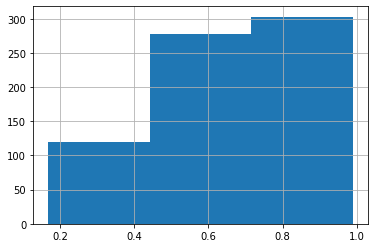

In [ ]:
Train_percent = 100/100
fraction_of_rows = Concatenated_data.sample(frac=Train_percent,random_state=2)
fraction_of_rows = fraction_of_rows.reset_index(drop=True)
labels = fraction_of_rows.iloc[:,9]
hist = labels.hist(bins=3)
#print(fraction_of_rows)
#print(labels)


In [ ]:
X_train = fraction_of_rows.iloc[:,0:9].values
y_train = fraction_of_rows.iloc[:,-1].values

X_test = Test_set.iloc[:,0:9].values
y_test = Test_set.iloc[:,-1].values

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)

0.8924814002375309
0.04541163473157576
0.9152024825281871
0.042553860224725404


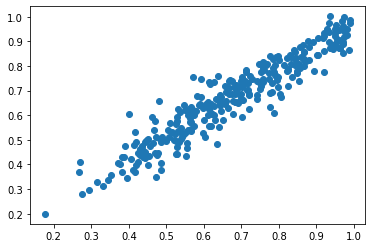

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions1 = model_poly.predict(x_poly_train)
predictions2 = model_poly.predict(x_poly_test)
fig = plt.scatter(y_test,predictions2)
#plt.savefig('test.pdf')

mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
mae_2_train = metrics.mean_absolute_error(y_train,predictions1)
r2_2_train = r2_score(y_train,predictions1)
r2_2 = r2_score(y_test,predictions2)  
print(r2_2)
print(mae_2)
print(r2_2_train)
print(mae_2_train)




In [ ]:
p1 = np.random.rand(1,1000);
p2 = np.random.rand(1,1000);
p3 = np.random.rand(1,1000);
p4 = np.random.rand(1,1000);

S = p1 + p2 + p3 + p4 

p1 = p1*np.reciprocal(S)
p2 = p2*np.reciprocal(S)
p3 = p3*np.reciprocal(S)
p4 = p4*np.reciprocal(S)

h = -1*(p1*np.log2(p1) + p2*np.log2(p2) + p3*np.log2(p3) + p4*np.log2(p4))

p1.shape

(1, 1000)

In [ ]:
import pandas as pd
import numpy as np
p11 = np.array(p1.T)
p21 = np.array(p2.T)
p31 = np.array(p3.T)
p41 = np.array(p4.T)
label = np.array(h.T)
dataset = pd.DataFrame(np.hstack((p11, p21, p31, p41, label)))

#print(dataset.head())

X = dataset.iloc[:,0:4].values
Y = dataset.iloc[:,-1].values

X.shape


(1000, 4)

In [ ]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(Shuffled_simulated_data.iloc[:,[2,5,8]].values, Shuffled_simulated_data.iloc[:,-1].values, test_size=0.33, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)




print('First two rows of the training dataset\n',X_train[0:2,:])
print('\nShape of the training dataset = ', X_train.shape)

print('\nFirst two rows of the test dataset\n', X_test[0:2,:])
print('\nShape of the test dataset = ', X_test.shape)

First two rows of the training dataset
 [[0.35468744 0.19895912 0.44557186 0.00078158]
 [0.15668641 0.51742712 0.11421505 0.21167143]]

Shape of the training dataset =  (670, 4)

First two rows of the test dataset
 [[0.33031701 0.19133207 0.15498303 0.32336789]
 [0.25089215 0.40971124 0.2123969  0.12699971]]

Shape of the test dataset =  (330, 4)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=5)

x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.fit_transform(X_test)   

0.9929108847937226
0.010544775004433835
0.9965173471442266
0.008271665685627812


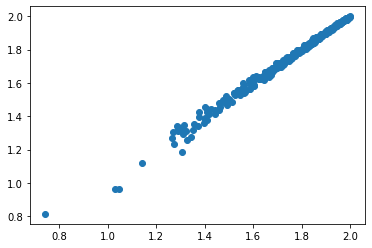

In [ ]:
model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
predictions1 = model_poly.predict(x_poly_train)
predictions2 = model_poly.predict(x_poly_test)
plt.scatter(y_test,predictions2)


mae_2 = metrics.mean_absolute_error(y_test,predictions2)
mse_2 = metrics.mean_squared_error(y_test,predictions2)
rmse_2 = np.sqrt(metrics.mean_squared_error(y_test,predictions2))
mae_2_train = metrics.mean_absolute_error(y_train,predictions1)
r2_2_train = r2_score(y_train,predictions1)
r2_2 = r2_score(y_test,predictions2)  
print(r2_2)
print(mae_2)
print(r2_2_train)
print(mae_2_train)